In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,calculate_shift_value


In [4]:
sheet = pd.read_excel('data_input/高硫燃料油380裂解价差.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')

sheet = sheet.rename(columns={'Singapore HSFO 380 crack': '新加坡高硫燃料油380裂解价差'})
sheet = sheet.rename(columns={'Weighted Refining Margin for Gasoline and Diesel in Shandong (with a weighting of one-third for gasoline and two-thirds for diesel)': '山东汽柴油加权裂解价差'})

last_day = sheet['新加坡高硫燃料油380裂解价差'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,新加坡高硫燃料油380裂解价差,布伦特迪拜掉期 EFS,稀释沥青贴水（LZ数据-brent）,布伦特原油期货价格30日环比,新加坡汽柴油加权利润（60%汽油40%柴油）,山东汽柴油加权裂解价差,路透-新加坡燃料油库存超季节性/3年/4WMA,Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓,高硫380EW价差超季节性/3年,Kpler-OPEC中东国家中质酸油+重质酸油出口量（周度）/4WMA超季节性/3年,Kpler-OPEC中东国家中质酸油+重质酸油出口量/轻质酸油出口量/4WMA超季节性/3年,荷兰天然气-新加坡高硫燃料油（等热值价差）同差,GPR地缘风险指数/20DMA,brent-dubai价差,Brent原油期货连1合约价格/路透,汽油出口利润（华东-新加坡）,柴油出口利润（华东-新加坡）,主要高硫出口地燃料油出口量当月环比变化-主要高硫进口地燃料油进口量当月环比变化/3MMA
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/eta/山东汽油裂解差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/eta/山东汽油裂解差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/汽柴煤油2.0/eta/山东汽油裂解差_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,预测值
27,2025-05-03,987.5430
26,2025-05-04,1008.4169
25,2025-05-05,1030.9303
24,2025-05-06,1026.7875
23,2025-05-07,1004.2721


In [6]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/eta/山东柴油裂解差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/eta/山东柴油裂解差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/汽柴煤油2.0/eta/山东柴油裂解差_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['实际值'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet2.head()

,Date,山东柴油裂解差
19,2025-05-14,729.78
18,2025-05-15,729.17
17,2025-05-16,724.69
16,2025-05-19,706.44
15,2025-05-20,707.99


In [7]:
# 尝试多个可能的文件路径
file_paths3 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/Brent原油价格_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/wti模型3.0/eta/Brent原油价格_合并数据.xlsx")
]

file_path3 = None
for path in file_paths3:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path3 = path
        break

if file_path3 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet3 = pd.ExcelFile(file_path3).parse('Sheet1')
    sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
    sheet3 = sheet3.sort_values('Date', ascending=True)
    sheet3['布伦特原油期货价格'] = sheet3['布伦特原油期货价格'].fillna(sheet3['Brent原油期货价格预测'])
    sheet3 = sheet3.drop(columns=['Brent原油期货价格预测'])
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet3.head()

,Date,布伦特原油期货价格
650,2023-06-02,76.13
649,2023-06-05,76.71
648,2023-06-06,76.29
647,2023-06-07,76.95
646,2023-06-08,75.96


In [8]:
# 合并 sheet1 和 sheet2 的数据
liejie_jiaquan_df = pd.merge(sheet1[['Date', '预测值']], sheet2[['Date', '山东柴油裂解差']], on='Date', how='outer')
liejie_jiaquan_df = liejie_jiaquan_df.sort_values('Date')
liejie_jiaquan_df['汽柴油加权裂解价差'] = (liejie_jiaquan_df['预测值'] + 2 * liejie_jiaquan_df['山东柴油裂解差']) / 3
liejie_jiaquan_df = liejie_jiaquan_df.drop(columns=['预测值', '山东柴油裂解差'])
liejie_jiaquan_df = liejie_jiaquan_df.dropna()
liejie_jiaquan_df.head()


,Date,汽柴油加权裂解价差
11,2025-05-14,807.521467
12,2025-05-15,812.216500
13,2025-05-16,806.843500
16,2025-05-19,796.475600
17,2025-05-20,797.814767


In [9]:
# 尝试多个可能的文件路径
file_paths5 = [
    os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/eta/汽油出口利润-华东-新加坡_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/eta/汽油出口利润-华东-新加坡_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/汽柴煤油2.0/eta/汽油出口利润-华东-新加坡_合并数据.xlsx")
]

file_path5 = None
for path5 in file_paths5:
    if os.path.isfile(path5):  # 确保是文件而不是目录
        file_path5 = path5
        break

if file_path5 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet5 = pd.ExcelFile(file_path5).parse('Sheet1')
    sheet5['Date'] = pd.to_datetime(sheet5['Date'], errors='coerce')
    sheet5 = sheet5.drop(columns=['真实值'])
    sheet5 = sheet5.dropna()
    sheet5 = sheet5.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet5.head()

,Date,预测值
29,2025-11-06,407.0
28,2025-11-07,636.2
27,2025-11-10,598.4
26,2025-11-11,603.5
25,2025-11-12,588.7


In [10]:
# 尝试多个可能的文件路径
file_paths6 = [
    os.path.expanduser("~/Desktop/X-BASE/汽柴煤油2.0/eta/柴油出口利润-华东-新加坡_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/汽柴煤油2.0/eta/柴油出口利润-华东-新加坡_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/汽柴煤油2.0/eta/柴油出口利润-华东-新加坡_合并数据.xlsx")
]

file_path6 = None
for path6 in file_paths6:
    if os.path.isfile(path6):  # 确保是文件而不是目录
        file_path6 = path6
        break

if file_path6 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet6 = pd.ExcelFile(file_path6).parse('Sheet1')
    sheet6['Date'] = pd.to_datetime(sheet6['Date'], errors='coerce')
    sheet6 = sheet6.drop(columns=['真实值'])
    sheet6 = sheet6.dropna()
    sheet6 = sheet6.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet6.head()

,Date,预测值
19,2025-11-06,370.8
18,2025-11-07,354.5
17,2025-11-10,213.7
16,2025-11-11,205.8
15,2025-11-12,199.4


In [11]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge( 
    sheet_daily,
    liejie_jiaquan_df[['Date', '汽柴油加权裂解价差']],
    on='Date',
    how='left'
)
sheet_daily['山东汽柴油加权裂解价差'] = sheet_daily['山东汽柴油加权裂解价差'].fillna(sheet_daily['汽柴油加权裂解价差'])
sheet_daily = sheet_daily.drop(columns=['汽柴油加权裂解价差'])

sheet_daily = pd.merge( 
    sheet_daily,
    sheet5[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['汽油出口利润（华东-新加坡）'] = sheet_daily['汽油出口利润（华东-新加坡）'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


sheet_daily = pd.merge( 
    sheet_daily,
    sheet6[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['柴油出口利润（华东-新加坡）'] = sheet_daily['柴油出口利润（华东-新加坡）'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')
sheet3 = sheet3.set_index('Date')
sheet = sheet.join(sheet3['布伦特原油期货价格'], how='left')

In [12]:
sheet.columns

Index(['新加坡高硫燃料油380裂解价差', '布伦特迪拜掉期 EFS', '稀释沥青贴水（LZ数据-brent）',
       '布伦特原油期货价格30日环比', '新加坡汽柴油加权利润（60%汽油40%柴油）', '山东汽柴油加权裂解价差',
       '路透-新加坡燃料油库存超季节性/3年/4WMA', 'Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓',
       '高硫380EW价差超季节性/3年', 'Kpler-OPEC中东国家中质酸油+重质酸油出口量（周度）/4WMA超季节性/3年',
       'Kpler-OPEC中东国家中质酸油+重质酸油出口量/轻质酸油出口量/4WMA超季节性/3年',
       '荷兰天然气-新加坡高硫燃料油（等热值价差）同差', 'GPR地缘风险指数/20DMA', 'brent-dubai价差',
       'Brent原油期货连1合约价格/路透', '汽油出口利润（华东-新加坡）', '柴油出口利润（华东-新加坡）',
       '主要高硫出口地燃料油出口量当月环比变化-主要高硫进口地燃料油进口量当月环比变化/3MMA', '布伦特原油期货价格'],
      dtype='object')

In [13]:
################################# 处理缺失值 #################################
fill_methods = {
'布伦特迪拜掉期 EFS': 'interpolate', 
'稀释沥青贴水（LZ数据-brent）': 'interpolate',
'布伦特原油期货价格30日环比': 'interpolate', 
'新加坡汽柴油加权利润（60%汽油40%柴油）': 'interpolate', 
'山东汽柴油加权裂解价差': 'interpolate',
'路透-新加坡燃料油库存超季节性/3年/4WMA': 'interpolate',
'布伦特原油期货价格': 'interpolate',
'Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓': 'interpolate',
'高硫380EW价差超季节性/3年': 'interpolate', 
'Kpler-OPEC中东国家中质酸油+重质酸油出口量（周度）/4WMA超季节性/3年': 'interpolate',
'Kpler-OPEC中东国家中质酸油+重质酸油出口量/轻质酸油出口量/4WMA超季节性/3年': 'interpolate', 
'荷兰天然气-新加坡高硫燃料油（等热值价差）同差': 'interpolate',
'GPR地缘风险指数/20DMA': 'interpolate',
'brent-dubai价差': 'interpolate',
'汽油出口利润（华东-新加坡）': 'interpolate', 
'柴油出口利润（华东-新加坡）': 'interpolate',
'主要高硫出口地燃料油出口量当月环比变化-主要高硫进口地燃料油进口量当月环比变化/3MMA': 'interpolate',
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['布伦特迪拜掉期 EFS_提前40天'] = sheet['布伦特迪拜掉期 EFS'].shift(40)
sheet['稀释沥青贴水（LZ数据-brent）_提前50天'] = sheet['稀释沥青贴水（LZ数据-brent）'].shift(50)
sheet['新加坡汽柴油加权利润（60%汽油40%柴油）_提前20天'] = sheet['新加坡汽柴油加权利润（60%汽油40%柴油）'].shift(20)
sheet['路透-新加坡燃料油库存超季节性/3年/4WMA_提前20天'] = sheet['路透-新加坡燃料油库存超季节性/3年/4WMA'].shift(20)
shift_value = calculate_shift_value(sheet, 'Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓', 2458,last_day_index=pd.Timestamp('2025-05-05'), default_shift=5)
sheet['Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓_提前5天'] = sheet['Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓'].shift(shift_value)
sheet['Kpler-OPEC中东国家中质酸油+重质酸油出口量/轻质酸油出口量/4WMA超季节性/3年_提前40天'] = sheet['Kpler-OPEC中东国家中质酸油+重质酸油出口量/轻质酸油出口量/4WMA超季节性/3年'].shift(40)
sheet['Kpler-OPEC中东国家中质酸油+重质酸油出口量（周度）/4WMA超季节性/3年_提前20天'] = sheet['Kpler-OPEC中东国家中质酸油+重质酸油出口量（周度）/4WMA超季节性/3年'].shift(20)
sheet['荷兰天然气-新加坡高硫燃料油（等热值价差）同差_提前40天'] = sheet['荷兰天然气-新加坡高硫燃料油（等热值价差）同差'].shift(40)
sheet['GPR地缘风险指数/20DMA_提前40天'] = sheet['GPR地缘风险指数/20DMA'].shift(40)
sheet['brent-dubai价差_提前15天'] = sheet['brent-dubai价差'].shift(15)


sheet['高硫380EW价差超季节性/3年_提前10天'] = sheet['高硫380EW价差超季节性/3年'].shift(10)

sheet['Brent原油期货价格30日环比'] = (sheet['布伦特原油期货价格'] - sheet['布伦特原油期货价格'].shift(30)) / sheet['布伦特原油期货价格'].shift(30)
sheet['布伦特原油期货价格30日环比'] = sheet['布伦特原油期货价格30日环比'].fillna(sheet['Brent原油期货价格30日环比'])

sheet['布伦特迪拜掉期 EFS_提前40天_逆序'] = reverse_column(sheet, '布伦特迪拜掉期 EFS_提前40天')
sheet['布伦特原油期货价格30日环比_逆序'] = reverse_column(sheet, '布伦特原油期货价格30日环比')
sheet['新加坡汽柴油加权利润（60%汽油40%柴油）_提前20天_逆序'] = reverse_column(sheet, '新加坡汽柴油加权利润（60%汽油40%柴油）_提前20天')
sheet['路透-新加坡燃料油库存超季节性/3年/4WMA_提前20天_逆序'] = reverse_column(sheet, '路透-新加坡燃料油库存超季节性/3年/4WMA_提前20天')
sheet['Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓_提前5天_逆序'] = reverse_column(sheet, 'Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓_提前5天')
sheet['Kpler-OPEC中东国家中质酸油+重质酸油出口量/轻质酸油出口量/4WMA超季节性/3年_提前40天_逆序'] = reverse_column(sheet, 'Kpler-OPEC中东国家中质酸油+重质酸油出口量/轻质酸油出口量/4WMA超季节性/3年_提前40天')
sheet['Kpler-OPEC中东国家中质酸油+重质酸油出口量（周度）/4WMA超季节性/3年_提前20天_逆序'] = reverse_column(sheet, 'Kpler-OPEC中东国家中质酸油+重质酸油出口量（周度）/4WMA超季节性/3年_提前20天')
sheet['brent-dubai价差_提前15天_逆序'] = reverse_column(sheet, 'brent-dubai价差_提前15天')
sheet['布伦特原油期货价格_逆序'] = reverse_column(sheet, '布伦特原油期货价格')
sheet['主要高硫出口地燃料油出口量当月环比变化-主要高硫进口地燃料油进口量当月环比变化/3MMA_逆序'] = reverse_column(sheet, '主要高硫出口地燃料油出口量当月环比变化-主要高硫进口地燃料油进口量当月环比变化/3MMA')

# 获取最后20个数据点
last_20_points = sheet.tail(20)

# 处理每一列
for col in ['brent-dubai价差_提前15天_逆序','Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓_提前5天_逆序','高硫380EW价差超季节性/3年_提前10天']:
    # 找出重复值
    duplicates = last_20_points[col][last_20_points[col].duplicated(keep='first')]
    # 如果重复值超过3个,保留第一个出现的值,其他置为空
    if len(duplicates) >= 3:
        sheet.loc[sheet.index[-20:], col] = sheet.loc[sheet.index[-20:], col].mask(
            lambda x: x.duplicated(keep='first')
        )

sheet[['brent-dubai价差_提前15天_逆序','Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓_提前5天_逆序','高硫380EW价差超季节性/3年_提前10天']]
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['新加坡高硫燃料油380裂解价差'].notna())
]

################################# 数据 读取-处理 结束 #################################

未找到Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓为2458的记录，使用默认shift值5


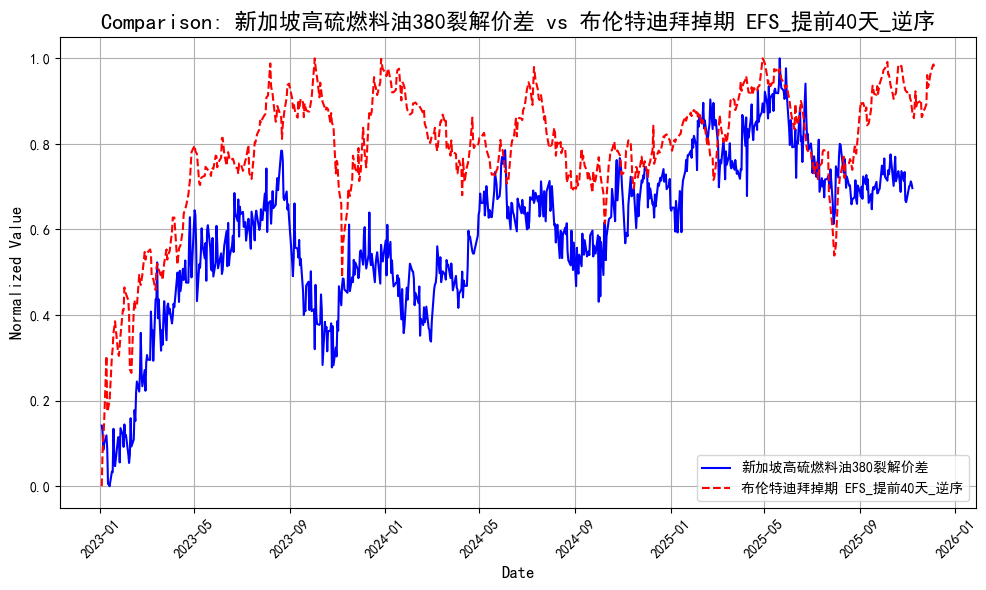

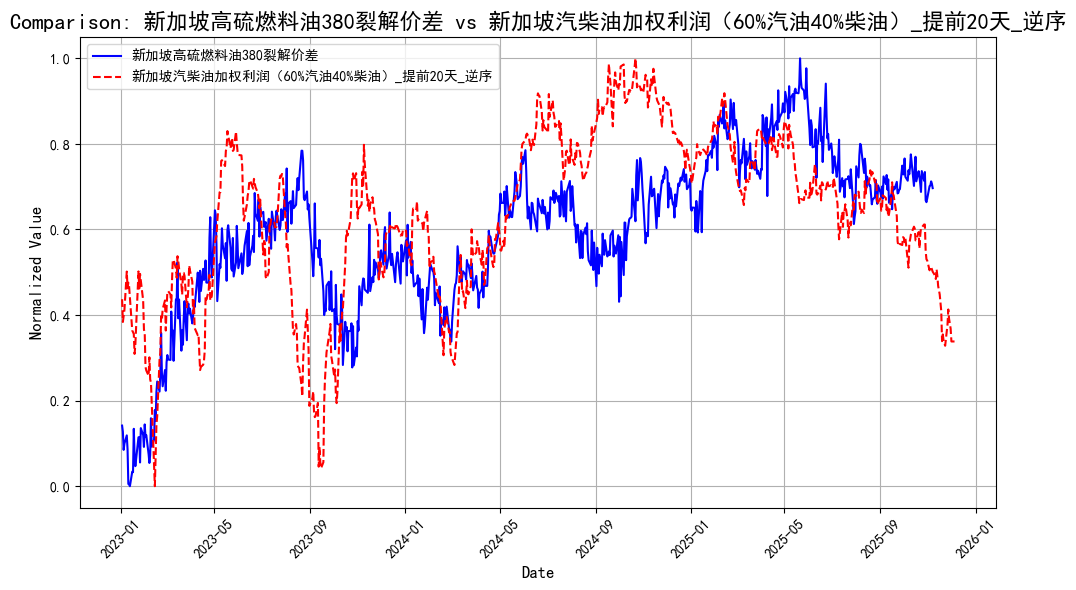

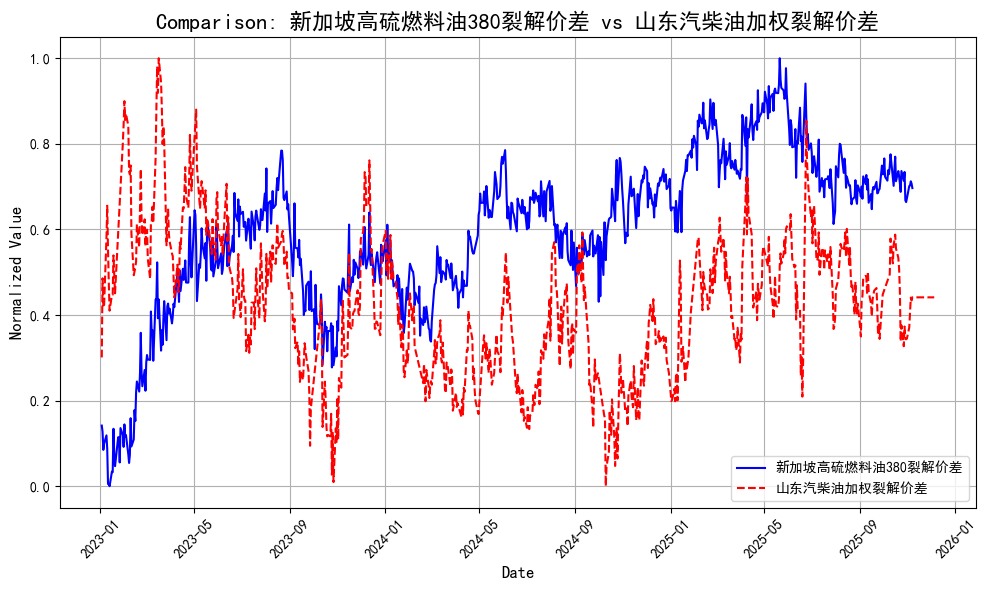

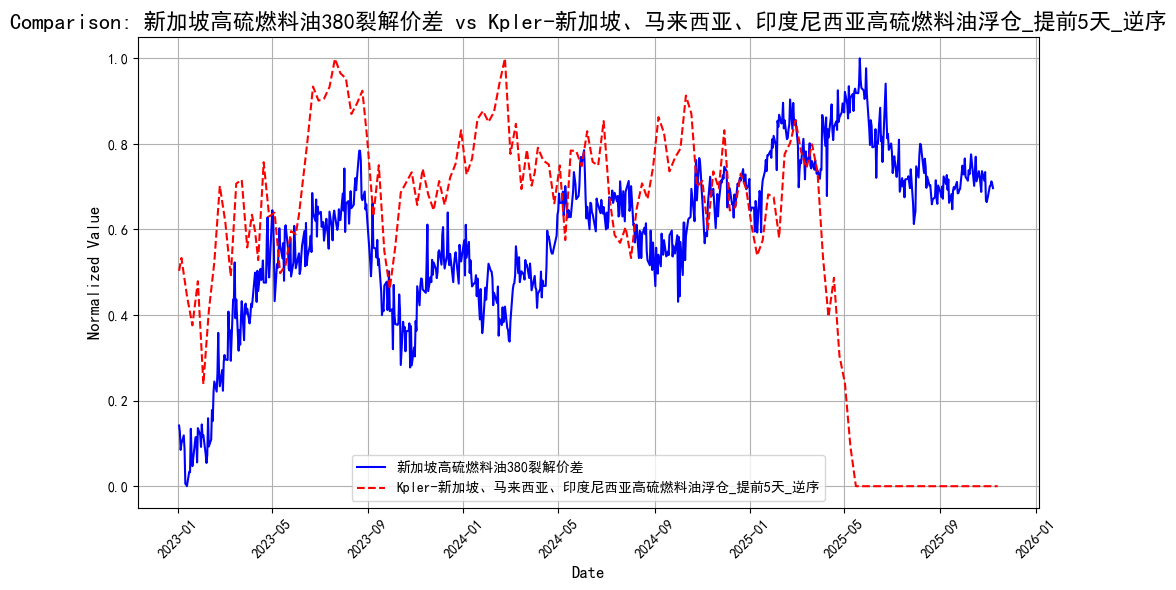

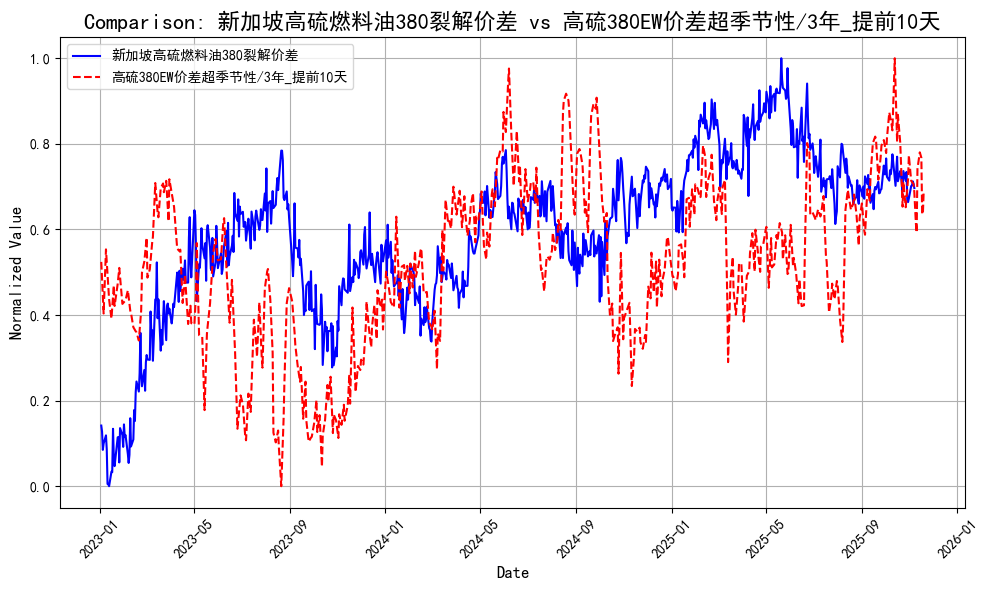

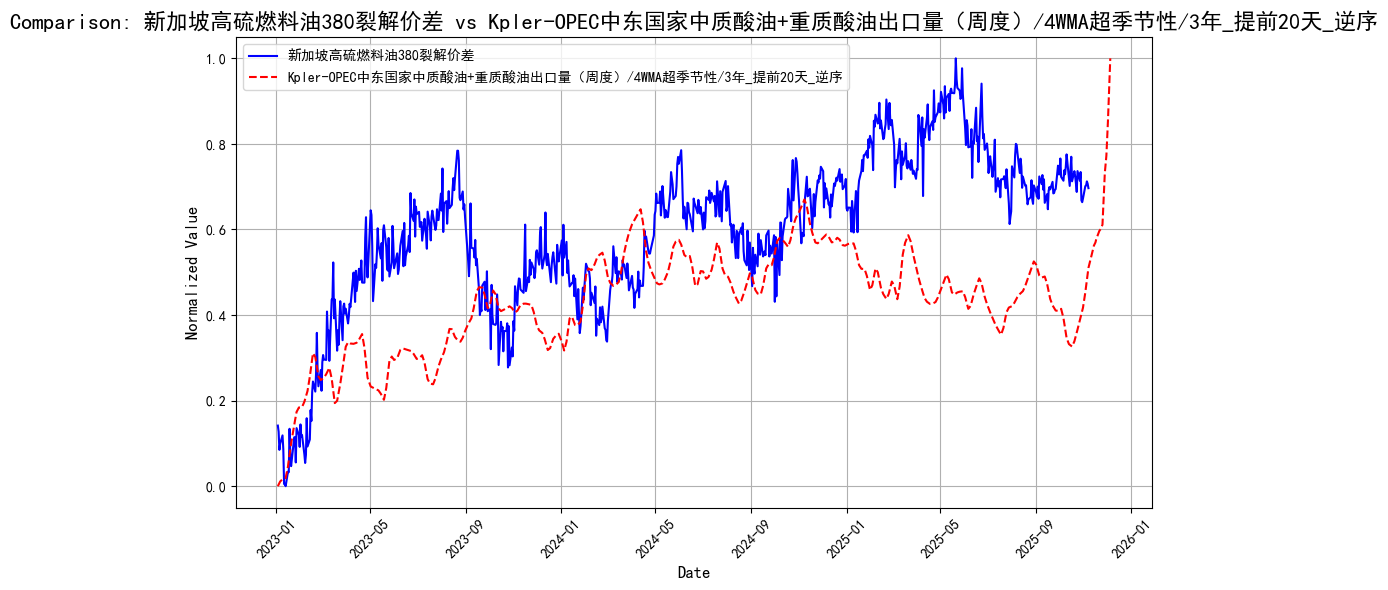

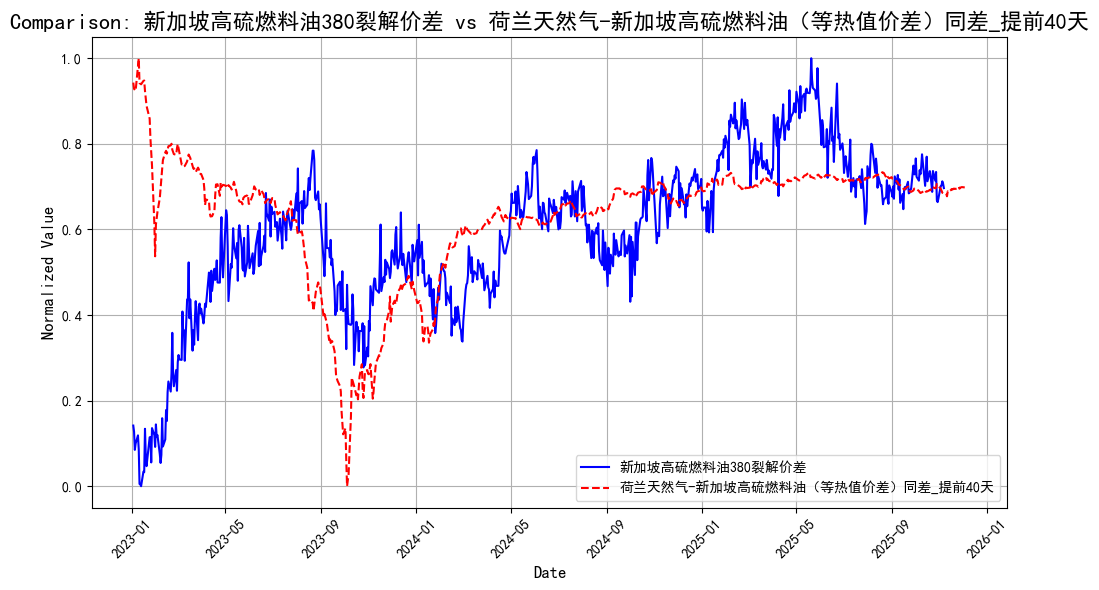

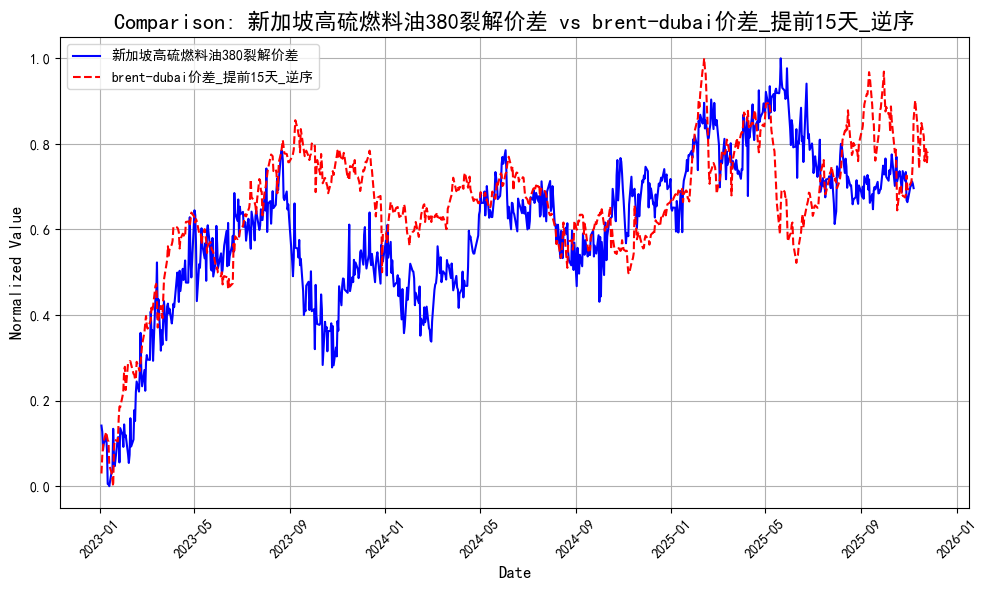

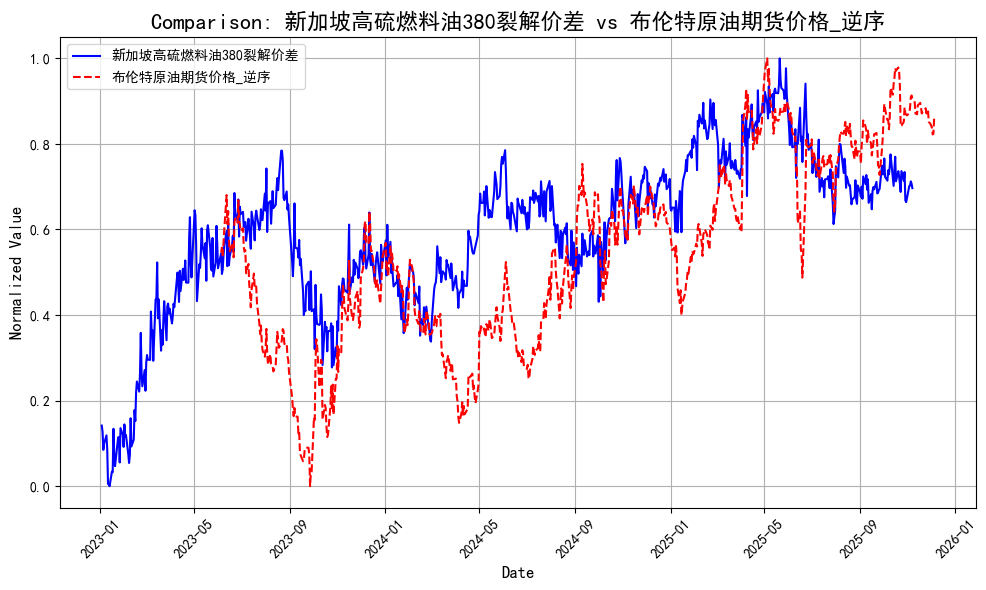

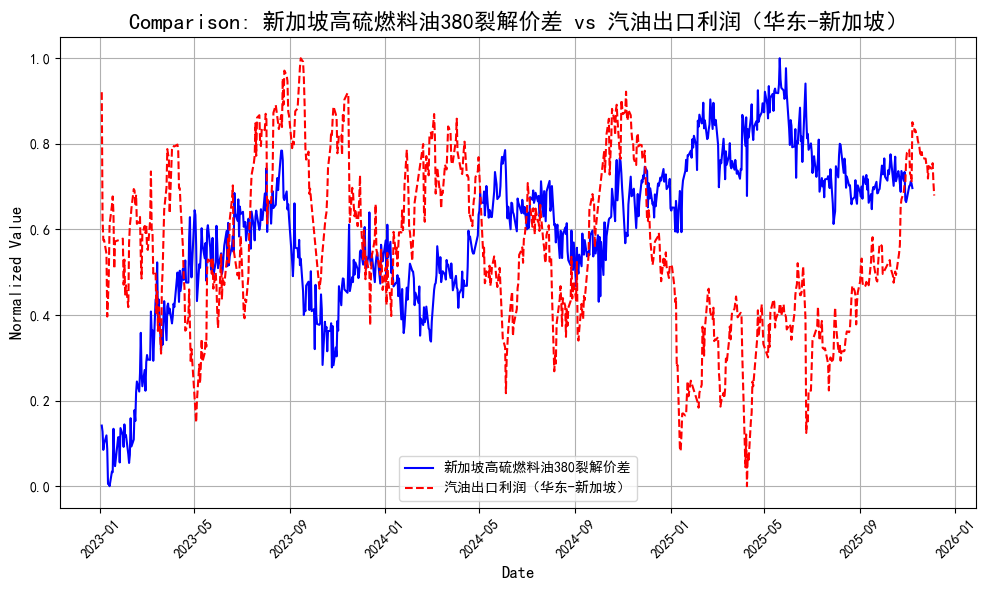

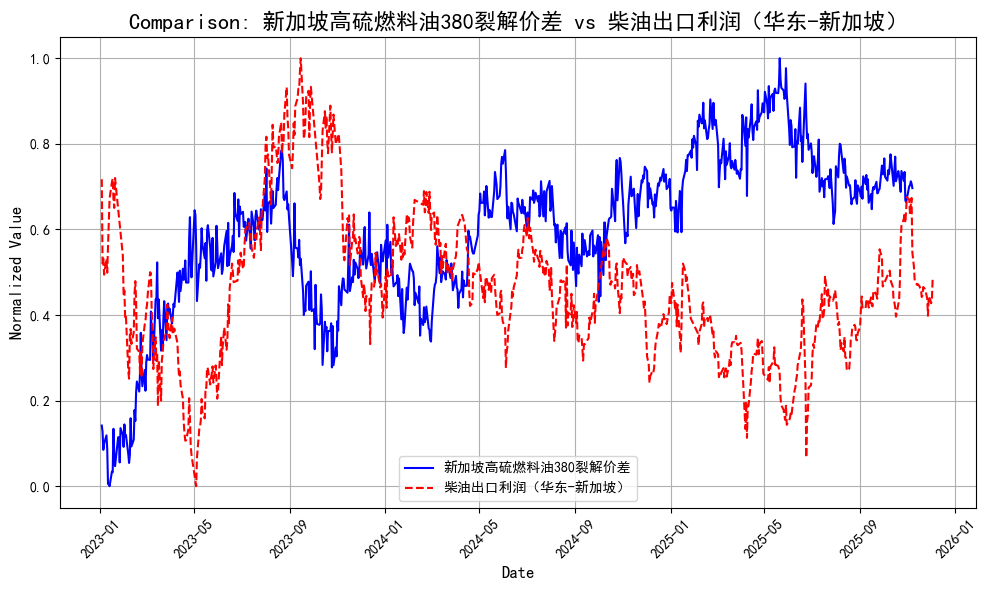

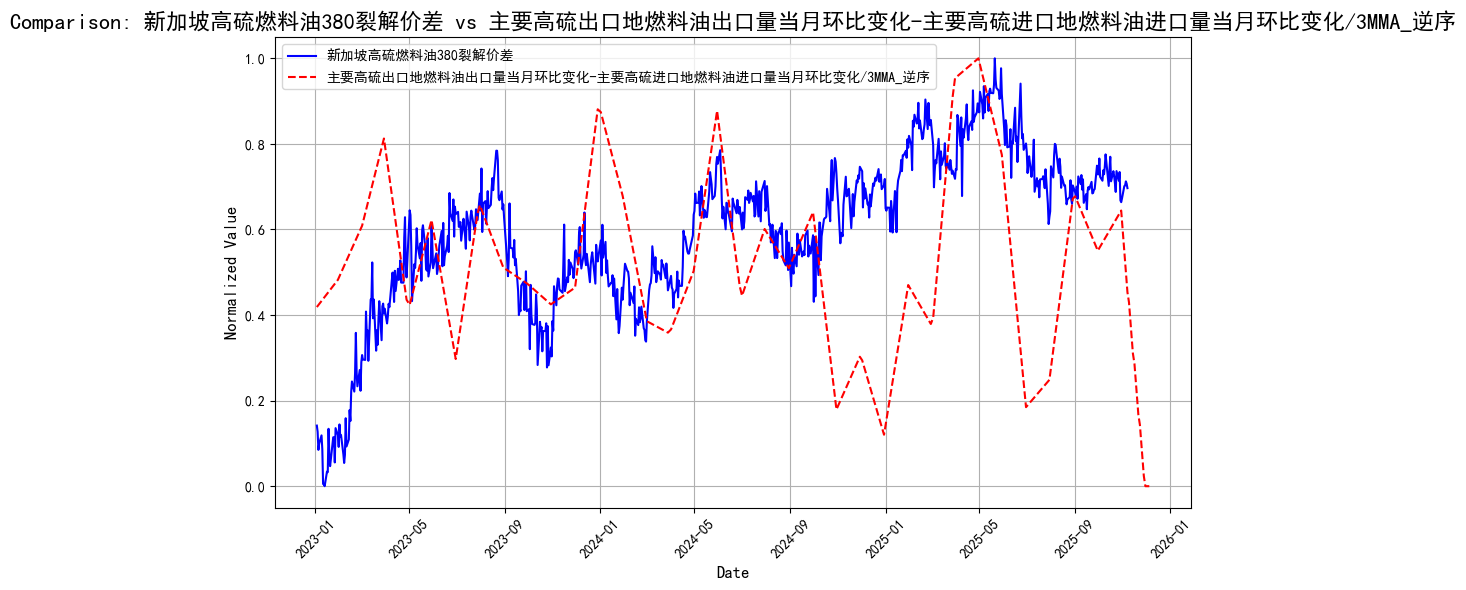

In [14]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='新加坡高硫燃料油380裂解价差', 
    compare_cols=[
        '布伦特迪拜掉期 EFS_提前40天_逆序',
        #'稀释沥青贴水（LZ数据-brent）_提前50天',
        #'布伦特原油期货价格30日环比_逆序',
        '新加坡汽柴油加权利润（60%汽油40%柴油）_提前20天_逆序',
        '山东汽柴油加权裂解价差',
        #'路透-新加坡燃料油库存超季节性/3年/4WMA_提前20天_逆序',
        'Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓_提前5天_逆序',
        '高硫380EW价差超季节性/3年_提前10天',
        #'Kpler-OPEC中东国家中质酸油+重质酸油出口量/轻质酸油出口量/4WMA超季节性/3年_提前40天_逆序',
        'Kpler-OPEC中东国家中质酸油+重质酸油出口量（周度）/4WMA超季节性/3年_提前20天_逆序',
        '荷兰天然气-新加坡高硫燃料油（等热值价差）同差_提前40天',
        #'GPR地缘风险指数/20DMA_提前40天',
        'brent-dubai价差_提前15天_逆序',
        '布伦特原油期货价格_逆序',
        '汽油出口利润（华东-新加坡）',
        '柴油出口利润（华东-新加坡）',
        '主要高硫出口地燃料油出口量当月环比变化-主要高硫进口地燃料油进口量当月环比变化/3MMA_逆序',
        ]
)

In [15]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '布伦特迪拜掉期 EFS_提前40天_逆序',
        #'稀释沥青贴水（LZ数据-brent）_提前50天',
        #'布伦特原油期货价格30日环比_逆序',
        '新加坡汽柴油加权利润（60%汽油40%柴油）_提前20天_逆序',
        '山东汽柴油加权裂解价差',
        #'路透-新加坡燃料油库存超季节性/3年/4WMA_提前20天_逆序',
        'Kpler-新加坡、马来西亚、印度尼西亚高硫燃料油浮仓_提前5天_逆序',
        '高硫380EW价差超季节性/3年_提前10天',
        #'Kpler-OPEC中东国家中质酸油+重质酸油出口量/轻质酸油出口量/4WMA超季节性/3年_提前40天_逆序',
        'Kpler-OPEC中东国家中质酸油+重质酸油出口量（周度）/4WMA超季节性/3年_提前20天_逆序',
        '荷兰天然气-新加坡高硫燃料油（等热值价差）同差_提前40天',
        #'GPR地缘风险指数/20DMA_提前40天',
        'brent-dubai价差_提前15天_逆序',
        '布伦特原油期货价格_逆序',
        '汽油出口利润（华东-新加坡）',
        '柴油出口利润（华东-新加坡）',
        '主要高硫出口地燃料油出口量当月环比变化-主要高硫进口地燃料油进口量当月环比变化/3MMA_逆序'
]

predict_column = '新加坡高硫燃料油380裂解价差'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.012814224281984844, 
    'max_depth': 7, 
    'min_child_weight': 2.9070153537181587, 
    'subsample': 0.6006912599357911, 
    'colsample_bytree': 0.9671428492510348, 
    'gamma': 0.2984664852153809, 
    'reg_alpha': 0.4399298354851392, 
    'reg_lambda': 0.8166037873641154,
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 5,
#    'tree_method': 'auto'
}


num_boost_round = 1000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:3.53829	train-rmse:5.37582


[500]	eval-rmse:1.00900	train-rmse:0.43054


[999]	eval-rmse:1.05799	train-rmse:0.31247


训练集 MSE (DMatrix): 0.1025, 训练集 R² (DMatrix): 0.997
测试集 MSE (DMatrix): 1.1193, 测试集 R² (DMatrix): -0.6625


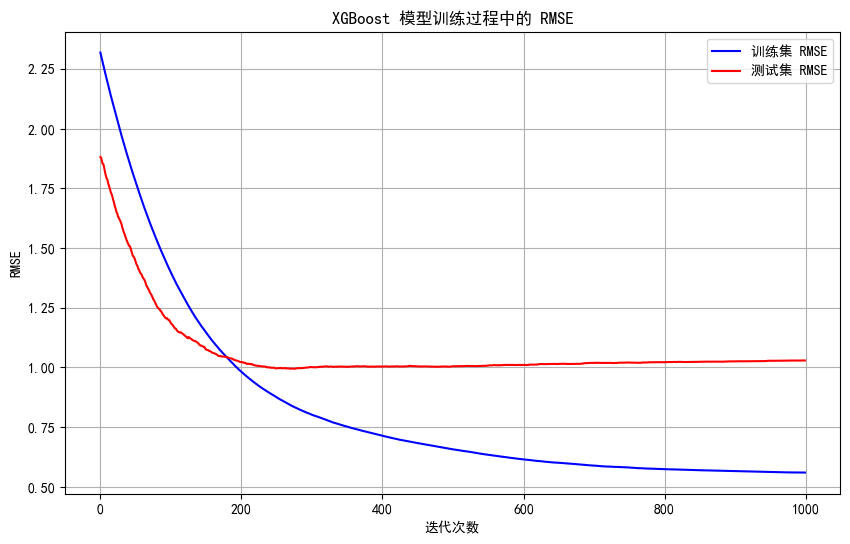

In [16]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:5.32982


[500]	train-rmse:0.42248


[999]	train-rmse:0.31087


全部数据 MSE: 0.1013, 全部数据 R²: 0.997


Gap between last actual value and first prediction: -0.4916897254943846


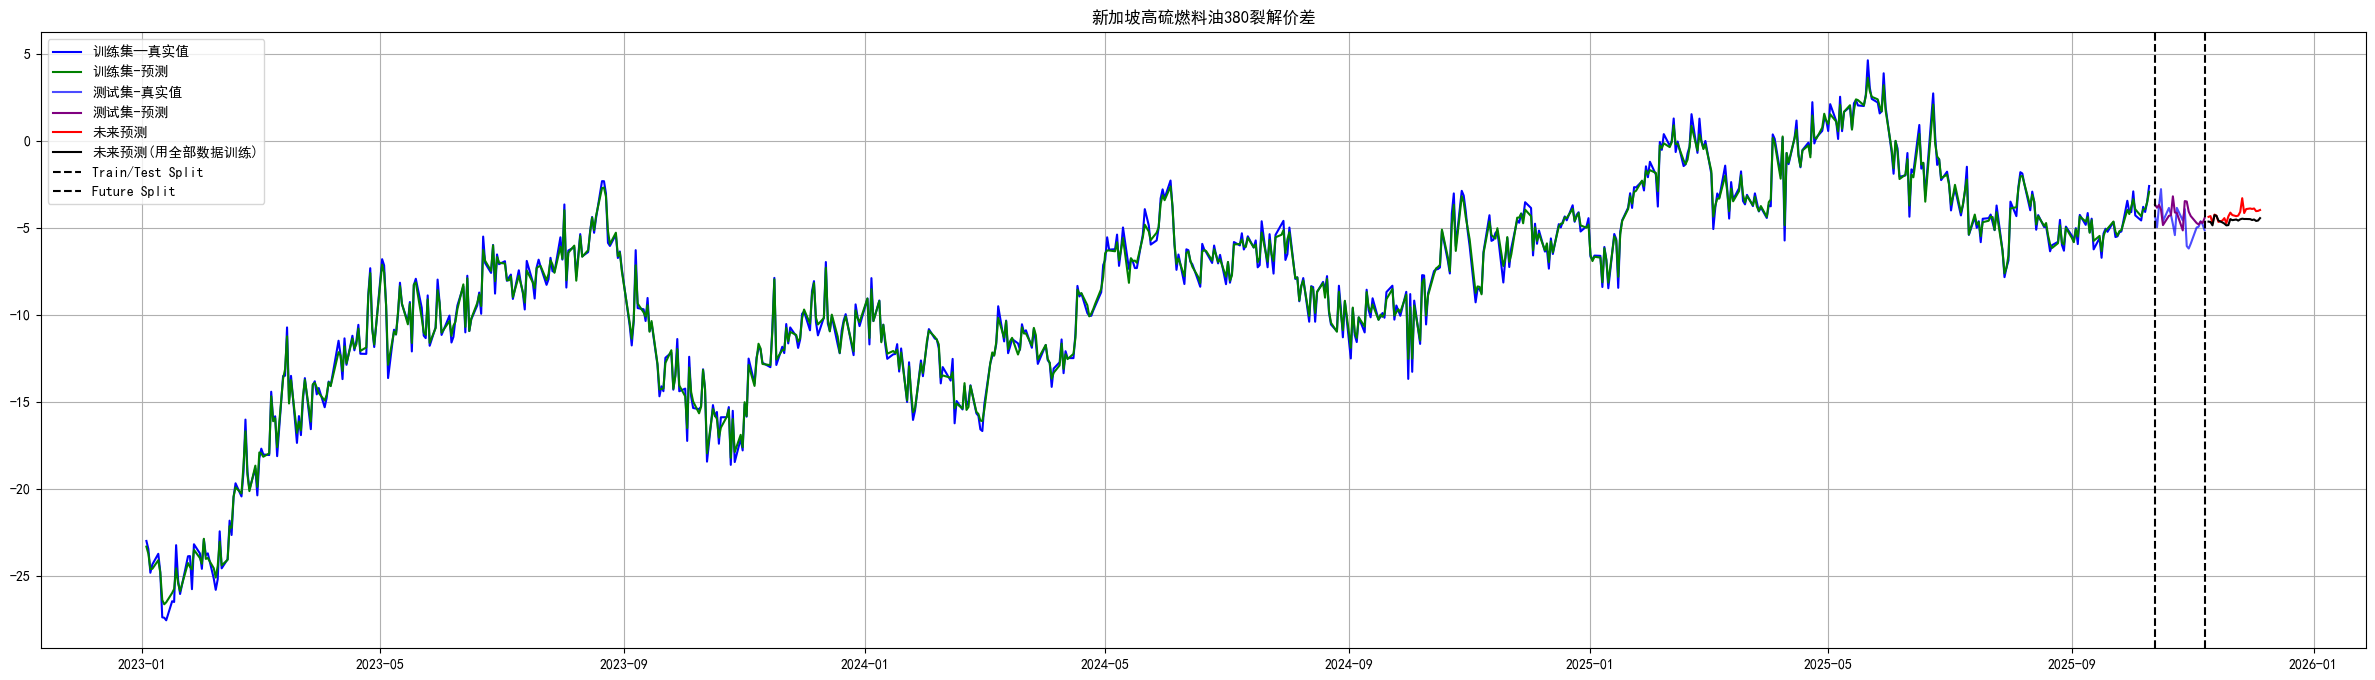

In [18]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('新加坡高硫燃料油380裂解价差')
plt.legend()
plt.grid(True)
plt.show()

---

In [19]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/新加坡高硫燃料油380裂解价差_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily.head() 

,Date,真实值,预测值
755,2025/12/05,NaN,-4.458457
754,2025/12/04,NaN,-4.596419
753,2025/12/03,NaN,-4.619459
752,2025/12/02,NaN,-4.534886
751,2025/12/01,NaN,-4.566430


In [20]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/新加坡高硫燃料油380裂解价差_月度数据.xlsx', index=False, float_format='%.4f')
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,-4.555130
34,2025/11/30,-4.912040,-4.618138
33,2025/10/31,-4.324609,-3.938937
32,2025/09/30,-5.151650,-5.116959
31,2025/08/31,-4.388086,-4.355810


In [21]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.燃料油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "新加坡高硫燃料油380裂解价差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [22]:
from Lcel import update_excel_data
file_path = "eta/1.燃料油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "新加坡高硫燃料油380裂解价差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
